In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

pd.set_option('max_columns',100)

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
def check_info(df):
    # show dataframe for each features that we have
    dataFeatures = []
    dataType     = []
    null         = []
    nullPCT      = []
    unique       = []
    minValue     = []
    maxValue     = []
    uniqueSample = []


    for item in list(df):
        dataFeatures.append(item)

    for item in dataFeatures:
        dataType.append(df[item].dtype.name)

    for item in dataFeatures:
        null.append(len(df[df[item].isnull() == True]))

    for item in dataFeatures:
        nullPCT.append(round(len(df[df[item].isnull() == True])/len(df[item])*100,2))

    for item in dataFeatures:
        minValue.append(df[item].min())

    for item in dataFeatures:
        maxValue.append(df[item].max())

    for item in dataFeatures:
        unique.append(df[item].nunique())

    for item in dataFeatures:
        uniqueSample.append(df[item].unique()[0:2])

    df_info = pd.DataFrame({
        'dataFeatures' : dataFeatures,
        'dataType' : dataType,
        'null' : null,
        'nullPCT':nullPCT,
        'unique' : unique,
        'minValue' : minValue,
        'maxValue' : maxValue,
        'uniqueSample':uniqueSample
    })
    
    return df_info

df_info = check_info(train)

In [4]:
percent20UP = list(df_info[df_info['nullPCT'] >= 20.0]['dataFeatures'])
percent20UP

['FH2O',
 'FNOX',
 'FOPTIMETHGLY',
 'FOXID',
 'FSO4',
 'FTBN',
 'FUEL',
 'SOOTPERCENTAGE',
 'U100',
 'U75',
 'U50',
 'U25',
 'U20',
 'U14',
 'U6',
 'U4',
 'V100']

In [5]:
# get dummies
dff = train.drop(percent20UP,axis=1)
dff = dff.fillna(0)
dff = pd.get_dummies(dff,columns=['COMPONENT_ARBITRARY'])


# data split
target = 'Y_LABEL'
features_for_model = [f for f in list(dff) if f not in [target,'ID']]

X = dff[features_for_model]
y = dff[target]

# data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                 test_size=0.2, 
                                                 random_state=101)

In [6]:
from xgboost import XGBClassifier

modelC = XGBClassifier(random_state=101)
modelC.fit(X_train,y_train)

prediction_train = modelC.predict(X_train)
prediction_test  = modelC.predict(X_test)

print(classification_report(y_train,prediction_train))
print(classification_report(y_test,prediction_test))

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10309
           1       1.00      0.97      0.98       967

    accuracy                           1.00     11276
   macro avg       1.00      0.98      0.99     11276
weighted avg       1.00      1.00      1.00     11276

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2583
           1       0.92      0.56      0.69       236

    accuracy                           0.96      2819
   macro avg       0.94      0.78      0.84      2819
weighted avg       0.96      0.96      0.95      2819



In [7]:
# Model Deployment

modelCD = XGBClassifier(random_state=101)
modelCD.fit(X,y)

prediction_proba = modelC.predict_proba(X)

[16:07:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [8]:
X2 = X.copy()
y2 = y.copy()

X2['proba'] = prediction_proba[:,0]

In [9]:
dft = test[:]
dft = dft.fillna(0)
dft = pd.get_dummies(dft,columns=['COMPONENT_ARBITRARY']).drop('ID',axis=1)

In [10]:
list_test_cols = dft.columns

In [11]:
X2 = X2[list_test_cols]
y2 = y2

# data split
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, 
                                                 test_size=0.2, 
                                                 random_state=101)

In [12]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


modelR = xgb.XGBRegressor(random_state=101)
modelR.fit(X_train2, y_train2)

prediction_train2 = modelR.predict(X_train2)
prediction_test2  = modelR.predict(X_test2)

print(r2_score(y_train2, prediction_train2))
print(r2_score(y_test2, prediction_test2))

0.6408182219760779
-0.07442646689254473


In [13]:
# Model Deployment

modelRD = xgb.XGBRegressor(random_state=101)
modelRD.fit(X2, y2)

prediction_proba2 = modelRD.predict(X2)

In [139]:
threshold = 0.25
pred_labels = np.where(np.array(prediction_proba2) > threshold, 1, 0)

In [140]:
len(pred_labels[pred_labels==1])

1033

In [141]:
len(pred_labels[pred_labels==0])

13062

In [142]:
print(classification_report(y,pred_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12892
           1       0.92      0.79      0.85      1203

    accuracy                           0.98     14095
   macro avg       0.95      0.89      0.92     14095
weighted avg       0.98      0.98      0.98     14095



In [143]:
print(classification_report(y,pred_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12892
           1       0.92      0.79      0.85      1203

    accuracy                           0.98     14095
   macro avg       0.95      0.89      0.92     14095
weighted avg       0.98      0.98      0.98     14095



In [144]:
result = modelRD.predict(dft)

In [145]:
result_labels = np.where(np.array(result) > threshold, 1, 0)

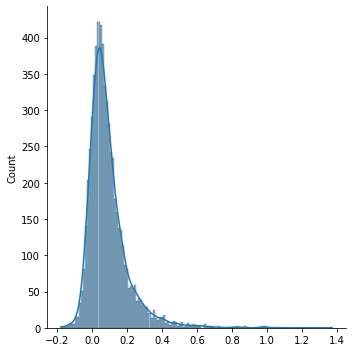

In [146]:
plt.rcParams["figure.figsize"] = (12,9)
sns.displot(result,kde=True)

In [147]:
submit = pd.read_csv('data/sample_submission.csv')
submit['Y_LABEL'] = result_labels
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,1


In [148]:
submit[submit['Y_LABEL']==0]

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
6,TEST_0006,0
...,...,...
6034,TEST_6034,0
6035,TEST_6035,0
6036,TEST_6036,0
6039,TEST_6039,0


In [149]:
submit[submit['Y_LABEL']==1]

,ID,Y_LABEL
4,TEST_0004,1
5,TEST_0005,1
32,TEST_0032,1
34,TEST_0034,1
51,TEST_0051,1
...,...,...
5978,TEST_5978,1
5987,TEST_5987,1
5997,TEST_5997,1
6037,TEST_6037,1


In [71]:
# submit.to_csv('submit_xgbdistilation.csv', index=False)